# Planetary Nebula <a class="tocSkip">
    
This notebook is used to test and showcase the results of my first project. I use spectroscopic data from the [Multi Unit Spectroscopic Explorer](https://www.eso.org/sci/facilities/develop/instruments/muse.html) (MUSE) that has been observed as part of the [PHANGS](https://sites.google.com/view/phangs/home) collaboration.
    
I will use a set of line maps of emission lines to identify Planetary Nebula in the data an measure their brightness. This can then be used to fit an empiric relation and hence measure the distance to the galaxy.
    
This notebook is used for developement. Final code is moved to the `pymuse` packge in the `src` folder. Any production scripts reside in the `scripts` folder.
    
## Load Basic Packages
    
First we load a bunch of common packages that are used across the project. More specific packages that are only used in one section are loaded later to make it clear where they belong to (this also applies to all custom moduls that were written for this project).

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

# some basic packages
import os                 # filesystem related stuff
from pathlib import Path  # use instead of os.path and glob
import sys                # mostly replaced by pathlib

import errno      # more detailed error messages
import warnings   # handles warnings
import logging    # use logging instead of print

from collections import OrderedDict  

# packages for scientific computing
import numpy as np
import scipy as sp

# packages for creating plots and figures
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# special functions for astronomy 
from astropy.table import Table  # useful datastructure
from astropy.table import vstack # combine multiple tables

from astropy.io import fits      # open fits files
from astropy.io import ascii     # handle normal files

from astropy.wcs import WCS               # handle coordinates
from astropy.coordinates import SkyCoord  # convert pixel to sky coordinates

from astropy.stats import sigma_clipped_stats  # calcualte statistics of images

import astropy.units as u        # handle units

In [25]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)

## Reference files

To test the detection routine we compare our results to those from Kreckel et al. (2017)

**Requires** (both already loaded with standard packages)
 * `astropy.io.ascii`
 * `astropy.coordinates.SkyCoord`

In [24]:
pn_kreckel = ascii.read(os.path.join('..','data','external','kreckel_pn_2017.txt'))

def string_to_ra(string):
    '''convert coordinates from Kreckel et al. (2017) to astropy
    
    the right ascension in the paper is given as 
    "01:36:42.212" but astropy requires "01h36m42.212s".
    This function replaces the ":" with the appropriate character.
    '''
    return string.replace(':','h',1).replace(':','m') + 's'

def string_to_dec(string):
    '''convert coordinates from Kreckel et al. (2017) to astropy
    
    the declination in the paper is given as "01:36:42.212" 
    but astropy requires "01d36m42.212s".
    This function replaces the ":" with the appropriate character.
    '''
    return string.replace(':','d',1).replace(':','m') + 's'

# convert string to astronomical coordinates
pn_kreckel['RA'] = list(map(string_to_ra,pn_kreckel['RA']))
pn_kreckel['DEC'] = list(map(string_to_dec,pn_kreckel['DEC']))
pn_kreckel['SkyCoord'] = SkyCoord(pn_kreckel['RA'],pn_kreckel['DEC'])

# select some subsets (PN from Hermann et al. 2008 or bright sources only)
pn_herrmann = pn_kreckel[[True if i.endswith('a') else False for i in pn_kreckel['ID']]]
pn_bright = pn_kreckel[pn_kreckel['mOIII']<27]

## Read in data

this uses the `ReadLineMaps` class from the `pymuse.io` module. To use it, we first need to specify the path to the data folder

In [26]:
from pymuse.io import ReadLineMaps

# first we need to specify the path to the raw data
data_raw = Path('d:\downloads\MUSEDAP')

# list all files in the specified directory
galaxies = [x.name for x in data_raw.iterdir() if x.is_dir()]
print(', '.join(map(str,galaxies)))

IC5332, NGC1087, NGC1365, NGC1512, NGC1566, NGC1672, NGC2835, NGC3351, NGC3627, NGC4254, NGC4535, NGC5068, NGC628, NGC628p


In [27]:
NGC628 = ReadLineMaps(data_raw / 'NGC628')
print(NGC628)

INFO:pymuse.io:loading NGC628
INFO:pymuse.io:replacing OIII5006 map
INFO:pymuse.io:file loaded with 4 extensions
name: NGC628
filename
lines
header
wcs
shape
whitelight
OIII5006
OIII5006_err
HA6562
HA6562_err
NII6583
NII6583_err
SII6716
SII6716_err
OIII5006_DAP
OIII5006_DAP_err
PSF



## Source Detection

### Based on IRAFStarFinder or DAPStarFinder

the following function is based on this tutorial 

https://photutils.readthedocs.io/en/stable/detection.html

https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder

**requires**
 * A `photutils` starfinder. This can be either `DAOStarFinder` or `IRAFStarFinder`
 * `detect_unresolved_sources`

In [28]:
from photutils import DAOStarFinder            # DAOFIND routine to detect sources
from photutils import IRAFStarFinder           # IRAF starfind routine to detect star

from pymuse.detection import detect_unresolved_sources

In [29]:
sources = detect_unresolved_sources(NGC628,
                                    'OIII5006',
                                    StarFinder=DAOStarFinder,
                                    threshold=4,
                                    PSF_size = 1.3,
                                    save=True)

INFO:pymuse.detection:searching for sources in NGC628 with [OIII5006] line map (using DAOStarFinder)

INFO:pymuse.detection:     fwhm   #N    mean  median     std
INFO:pymuse.detection:  2.965px  452 -20.635 -18.986  64.410
INFO:pymuse.detection:  3.170px 1690   9.170   6.612  65.659
INFO:pymuse.detection:  3.380px  925  14.197  12.709  72.815
INFO:pymuse.detection:  3.560px  800   8.480   6.830  52.456
INFO:pymuse.detection:  3.565px  770  23.187  20.548  96.385
INFO:pymuse.detection:  3.685px  467   3.503   2.131  42.914
INFO:pymuse.detection:  3.715px 1096   4.676   3.644  53.491
INFO:pymuse.detection:  3.815px  572  12.341  10.777  66.585
INFO:pymuse.detection:  3.875px  475   9.525   7.874  50.826
INFO:pymuse.detection:  4.090px  441  13.787  12.078  44.149
INFO:pymuse.detection:  total   7688


#### Compare to Kreckel et al. 2017

In [8]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)

In [9]:
tolerance = '0.3"'
ID, angle, Quantity  = match_coordinates_sky(pn_bright['SkyCoord'],sources['SkyCoord'])
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'{within_tolerance} of {len(angle)} match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')
print(f'mean seperation is {angle.mean().to_string(u.arcsec,decimal=True)}"')

28 of 36 match within 0.3"": 77.8 %
mean seperation is 0.349478"


#### Plot detected sources

In [104]:
from pymuse.plot import plot_sky_with_detected_stars

In [ ]:
position = np.transpose((sources['x'], sources['y']))
positions_kk = np.transpose(pn_bright['SkyCoord'].to_pixel(wcs=NGC628.wcs))
positions = (position,positions_kk)

save_file = Path.cwd() / '..' / 'reports' / 'figures' / f'{NGC628.name}_sky_sources_DAO.pdf'
plot_sky_with_detected_stars(data=NGC628.OIII5006_old,
                             wcs=NGC628.wcs,
                             positions=positions,
                             filename=save_file)

#### Cut out detected stars

In [ ]:
from pymuse.plot import sample_cutouts

In [ ]:
save_file = Path.cwd() / '..' / 'reports' / 'figures' / f'{NGC628.name}_stars.pdf'

stars = sample_cutouts(NGC628.OIII5006_old,sources,NGC628.wcs,nrows=4,ncols=4)

### Using SExtractor

there is no Python implementation of SExtractor. Instead we run it from the command line

```
sextractor file.fits -c default.sex
```

this will produce a file `test.cat` which contains the position of the sources. We read this table and calculate the sky position wiht astropy

In [ ]:
file = Path.cwd() / '..' / 'data' / 'interim' / 'NGC628.cat'

table = ascii.read(file)
table['SkyCoord'] = SkyCoord.from_pixel(table['X_IMAGE'],table['Y_IMAGE'],NGC628.wcs)

print(f'{len(table)} sources found')

In [ ]:
sources = Table()
sources['x'] = table['X_IMAGE']
sources['y'] = table['Y_IMAGE']
sources['SkyCoord'] = table['SkyCoord']
sources['fwhm'] = 0.8
NGC628.sources = sources

#### Match with known sources

In [ ]:
ID, angle, Quantity  = match_coordinates_sky(pn_bright['SkyCoord'],table['SkyCoord'])
within_1_arcsec = len(angle[angle.__lt__(Angle("0.5s"))])

print(f'{within_1_arcsec} of {len(angle)} match within 0.5": {within_1_arcsec / len(angle)*100:.1f} %')
print(f'mean seperation is {angle.mean().to_string(u.arcsec,decimal=True)}"')
#print(f'mean angle: {angle.mean():.2f}')

#### Plot detected sources

this requires the previously loaded `plot_sources` from `pymuse.plot`

In [ ]:
file = Path.cwd() / '..' / 'reports' / 'figures' / f'{NGC628.name}_sources_sextractor.pdf'

position = np.transpose((sources['x'], sources['y']))
references = np.transpose(pn_bright['SkyCoord'].to_pixel(wcs=NGC628.wcs))
positions = (position,references)

sky_with_detected_stars(data=NGC628.OIII5006_old,wcs=NGC628.wcs,positions=positions,filename=file)

### Old line maps

here we are using the line maps that were used in Kreckel et al. 2017

In [ ]:
from photutils import find_peaks

In [ ]:
data_folder = os.path.join('d',os.sep,'downloads','MUSEDAP')
with fits.open(os.path.join(data_folder,'NGC628p','NGC628p_MAPS.fits')) as hdul:
    data = hdul[0].data
    header = hdul[0].header

with fits.open(os.path.join(data_folder,'NGC628p','NGC628p_MAPS_err.fits')) as hdul:
    err = hdul[0].data


In [ ]:
mean, median, std = sigma_clipped_stats(err[~np.isnan(err)], sigma=3.0)

# initialize daofind 
# FWHM is given in arcsec. one pixel is 0.2" 
StarFinder = DAOStarFinder(fwhm=0.8/0.17, 
                           threshold=8.*median,
                           sharplo=0.1, 
                           sharphi=1.0,
                           roundlo=-1,
                           roundhi=1)

# for the source detection we subtract the sigma clipped median
#sources_old = find_peaks(data,12*median,box_size=6)
sources_old = StarFinder(data)

print(f'{len(sources_old):>5.0f}{mean:>8.3f}{median:>8.3f}{std:>8.3f}')

# for consistent table output
for col in sources_old.colnames:
    sources_old[col].info.format = '%.8g'  

sources_old.rename_column('xcentroid','x')
sources_old.rename_column('ycentroid','y')
    
# calculate astronomical coordinates
sources_old['SkyCoord'] = SkyCoord.from_pixel(sources_old['x'],sources_old['y'],WCS(header))
#sources['RaDec'] = sources['SkyCoord'].to_string(style='hmsdms',precision=2)

ID, angle, Quantity  = match_coordinates_sky(pn_bright['SkyCoord'],sources_old['SkyCoord'])
within_1_arcsec = len(angle[angle.__lt__(Angle("0.5s"))])

print(f'{within_1_arcsec} of {len(angle)} match within 0.5": {within_1_arcsec / len(angle)*100:.1f} %')
print(f'mean seperation is {angle.mean().to_string(u.arcsec,decimal=True)}"')

In [ ]:
file = Path.cwd() / '..' / 'reports' / 'figures' / 'sources_old.pdf'

position = np.transpose((sources_old['x'], sources_old['y']))
references = np.transpose(pn_bright['SkyCoord'].to_pixel(wcs=WCS(header)))
positions = (position,references)

plot_sources(data=data,wcs=WCS(header),positions=positions)
                          
plt.xlim([1300,2900])
plt.ylim([1800,3300])

plt.savefig(file)

### Find sources in mock data

In [ ]:
from collections import OrderedDict
from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)

from photutils import CircularAperture
from astropy.stats import gaussian_sigma_to_fwhm

from astropy.visualization import simple_norm

In [ ]:

def test_detection(StarFinder_Algorithm,sigma_psf,amplitude,PSF_size=1):
    '''create an image with mock sources and try to detect them
    
    Parameters
    ----------
        
    StarFinder_Algorithm:
         Class to detect stars
    
    sigma_psf:
        standard deviation of the PSF of the mock sources 
    
    amplitude:
        amplitude of the mock sources
        
    PSF_size: 
        The StarFinder_Algorithm need to know the sigma of the sources
        they try to detect. This parameter changes the provided size 
        compared to the sigma of the mock sources.
    '''
    
    # create mock data
    n_sources = 20
    tshape = (256,256)

    param_ranges = OrderedDict([
                    ('amplitude', [amplitude, amplitude*1.2]),
                    ('x_mean', [0,tshape[0]]),
                    ('y_mean', [0,tshape[1]]),
                    ('x_stddev', [sigma_psf,sigma_psf]),
                    ('y_stddev', [sigma_psf, sigma_psf]),
                    ('theta', [0, 0]) ])

    sources = make_random_gaussians_table(n_sources, param_ranges,
                                          random_state=1234)

    image = (make_gaussian_sources_image(tshape, sources) +
             make_noise_image(tshape, type='poisson', mean=6.,
                              random_state=1) +
             make_noise_image(tshape, type='gaussian', mean=0.,
                              stddev=2., random_state=34234))

    fwhm = gaussian_sigma_to_fwhm * sigma_psf

    mean, median, std = sigma_clipped_stats(image, sigma=3.0)

    StarFinder = StarFinder_Algorithm(fwhm=fwhm*PSF_size, 
                                      threshold=3.*std,
                                      sharplo=0.1, 
                                      sharphi=1.0,
                                      roundlo=-.2,
                                      roundhi=.2)

    sources_mock = StarFinder(image)

    # for consistent table output
    for col in sources_mock.colnames:
        sources_mock[col].info.format = '%.8g'  

    string = str(StarFinder_Algorithm).split('.')[-1][:-2] + f' sig={sigma_psf} A={amplitude}'
    print(f'{string}: {len(sources_mock):} of {n_sources} sources found')

    positions = np.transpose([sources_mock['xcentroid'],sources_mock['ycentroid']])
    apertures = CircularAperture(positions, r=fwhm)    
    
    return image, apertures, sources, string


nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10),
                        squeeze=True)
ax = ax.ravel()


amplitude_lst = [40,200]
sigma_lst = [2.,4.]
StarFinder_lst = [DAOStarFinder,IRAFStarFinder]


settings = []
for f in StarFinder_lst:
    for s in sigma_lst:
        for a in amplitude_lst:
            settings.append((f,s,a))
    
    
for i in range(nrows*ncols):
    f,s,a = settings[i]
    img, ap, sc, string = test_detection(f,s,a,PSF_size=1)
    
    norm = simple_norm(img, 'log', percent=99.)
    ax[i].imshow(img, norm=norm, origin='lower', cmap='viridis')
    ap.plot(color='red', lw=1., alpha=0.9,ax=ax[i])
    ax[i].scatter(sc['x_mean'],sc['y_mean'],color='red',s=1)
    ax[i].set_title(string)
    
plt.show()

## Completeness limit

In [ ]:
from pymuse.detection import completeness_limit

INFO:pymuse.detection:60 mock sources created
INFO:pymuse.detection:mock sources inserted into image
INFO:pymuse.detection:510 sources found
INFO:pymuse.detection:searching for best match


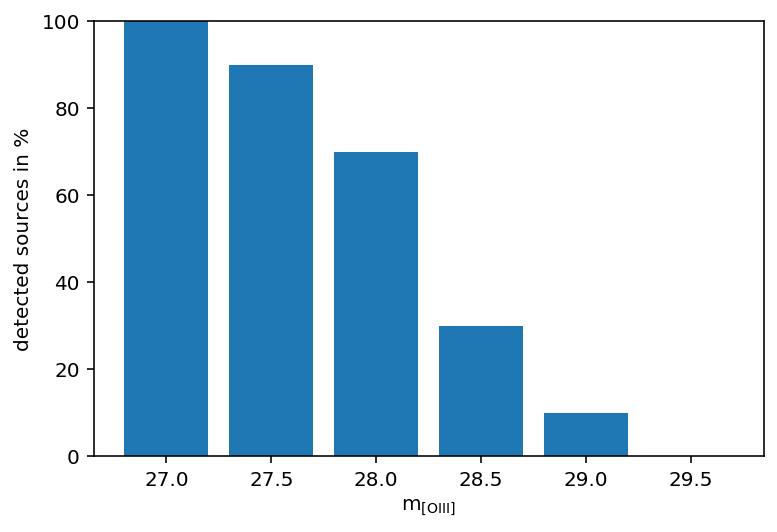

In [318]:
mock_sources = completeness_limit(NGC628,'OIII5006',DAOStarFinder,4,iterations=1,oversize_PSF=1.3)

## Flux measurement

### Percentage of flux in the aperture

for the PSF we assume a 2D gaussian that is centered around the origin and has a variance of $\sigma_x^2 = \sigma_y^2 = \sigma^2$ and an amplitude of $A$
$$
f(x,y) = A \exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)
$$
we can rewrite this in polar coordinates as 
$$
f(r,\phi) = A \exp\left(-\frac{r^2}{2\sigma^2}\right)
$$
The light inside an aperture of radius $P(R)$ is given by the integral
$$
P(R) = \int_0^{2\pi} \int_0^R f(r,\phi) \mathrm{d} \phi r \mathrm{d} r = 2\pi \sigma^2 A \left(1-\exp \left(-\frac{R^2}{2\sigma^2}\right) \right) 
$$
We are interested in the ratio $p(R) = P(R) / P(\infty)$. If we use that for a gaussian, the standard deviation and the $\mathrm{FWHM}$ are related by $\sigma = \frac{\mathrm{FWHM}}{2\sqrt{2\ln2}}=$, we can write
$$
\begin{align}
p(R) = 1-\exp\left(- \frac{4 \ln 2 \cdot R^2}{\mathrm{fwhm}^2} \right)
\end{align}
$$

In [ ]:
def light_in_aperture(radius,fwhm):
    '''
    p(r) = 1 - e^(-4 ln2 r^2/fwhm^2)
    
    Given a circular aperture with the specified radius, this function
    calculates the fraction of light inside the aperture if the 
    underlying distribution is a 2D gaussian with the specified fwhm.     
    '''
    
    return 1-np.exp(- 4*np.log(2)*radius**2 / fwhm**2)

d = np.linspace(0.5,4)
p = light_in_aperture(d/2,1)
plt.plot(d,100*p)
plt.xlabel('diameter in fwhm')
plt.ylabel('light in aperture in %')
plt.grid()

### Growth curve analysis

the previous calculation is based on two assumptions:
 1. The PSF has the shape of a 2D Gaussian
 2. We know the $\mathrm{FWHM}$ of said PSF
 
to validate those assumptions, we measure the flux as a function of aperture radius for different sources to check if if the shape is a Gaussian and to measure the real value of the $\mathrm{FWHM}$.

In [ ]:
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import aperture_photometry

import scipy.optimize as optimization

from pymuse.plot import single_cutout
from pymuse.photometry import light_in_aperture

In [ ]:
# we cannot sort a Table that has a SkyCoord object as a column
del sources['SkyCoord']

In [ ]:
# sort by brightness and select only sources from one pointing
sources.sort('peak',reverse=True)
PSF_fwhm = np.unique(sources['fwhm'])
sub = sources[(sources['fwhm']==PSF_fwhm[2])]

sub

In [ ]:
# select one of the bright sources and take a look at it
i = 3
x,y = sub[i][['x','y']]
guess=sub[i]['fwhm']
single_cutout(NGC628,'whitelight',x,y)
sub[i]

In [ ]:
# this requires the next cell
fit,sig = growth_curve(data,x,y,guess=0.8*guess,plot=True)
print(f'reported={guess:.2f}, measured={fit[0]:.2f}, ratio={fit[0]/guess:.2f}')

In [ ]:
data = NGC628.whitelight

def growth_curve(data,x,y,guess=5,plot=False):
    '''do a growth curve analysis on the given star
    
    measure the amount of light as a function of radius and tries
    to fit a Gaussian to the measured profile. Returns the FWHM
    of the Gaussian.
    '''
    
    # we measure the flux for apertures of different radii
    radius = np.arange(2,3.5*guess,1)
    flux = []

    for r in radius:
        aperture = CircularAperture((x,y), r=r)
        annulus_aperture = CircularAnnulus((x,y), r_in=r, r_out=2*r)
        mask = annulus_aperture.to_mask(method='center')
        annulus_data = mask.multiply(data)
        annulus_data_1d = annulus_data[mask.data > 0]
        _, bkg_median, _ = sigma_clipped_stats(annulus_data_1d[~np.isnan(annulus_data_1d)])
        phot = aperture_photometry(data,aperture)
        flux.append(phot['aperture_sum'][0]-aperture.area*bkg_median)
    flux = np.array(flux)   
    flux = flux/flux[-1]

    guess = 4
    fit = optimization.curve_fit(light_in_aperture, radius,flux , guess)
    fwhm = fit[0]

    if plot:
        plt.plot(radius,flux,label='observed')
        plt.plot(radius,light_in_aperture(radius,fwhm),label='fit')
        plt.xlabel('radius in px')
        plt.ylabel('light in aperture')
        plt.legend()
        plt.grid()

    
    return fit
    #print(f'fwhm={fwhm[0]:.2f} px')


In [ ]:
fwhm = []
sig = []

for row in sub:
    x,y = row[['x','y']]
    try:
        f,s = growth_curve(data,x,y,row['fwhm'])
        if any(s<0.1):
            fwhm.append(f[0])
            sig.append(s[0])
    except:
        pass
    
print(f'{np.mean(fwhm):.2f} +- {np.std(fwhm):.2f}')

In [ ]:
fwhm = sub[i]['fwhm']/0.2
print(fwhm)

radius_px = np.arange(1,20,0.1)
flux = []

for r in radius_px:
    aperture = CircularAperture((x,y), r=r)
    annulus_aperture = CircularAnnulus((x,y), r_in=r, r_out=2*r)
    mask = annulus_aperture.to_mask(method='center')
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, bkg_median, _ = sigma_clipped_stats(annulus_data_1d[~np.isnan(annulus_data_1d)])
    phot = aperture_photometry(data,aperture)
    flux.append(phot['aperture_sum'][0]-aperture.area*bkg_median)
    
flux = np.array(flux) 

p = light_in_aperture(radius_px/fwhm,1)
plt.plot(radius_px,flux/flux[-1]*100,label='observed')
plt.plot(radius_px,100*p,label='theory')
plt.legend()

plt.xlabel('radius in px')
plt.ylabel('light in aperture in %')
plt.grid()


### Aperture Photometry

we use the positions of the previously detected sources to measure the flux of different lines

https://photutils.readthedocs.io/en/stable/aperture.html

the values in the pixels are in units of $10^{-20} \ \mathrm{erg}  \ \mathrm{cm}^{-2} \ \mathrm{s}^{-1} / \mathrm{spaxel}$. To convert into apparent magnitudes we can use

$$
m_{[\mathrm{O\ III}]} = -2.5 \cdot \log F_{[\mathrm{O\ III}]} - 13.74
$$

where $F_{[\mathrm{O\ III}]}$ is given measured in $\mathrm{erg}  \ \mathrm{cm}^{-2} \ \mathrm{s}^{-1}$

$$
\Delta m_{[\mathrm{O\ III}]} = \sqrt{\left(\frac{-2.5 \cdot \Delta F_{[\mathrm{O\ III}]}}{\ln 10 \cdot F_{[\mathrm{O\ III}]}}\right)^2 }
$$

In [30]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)

from extinction import ccm89     # calculate extinction Cardelli et al. (1989)

from pymuse.photometry import measure_flux

In [31]:
#NGC628.lines.append('OIII5006_DAP')
# use diferent OIII map
flux = measure_flux(NGC628,aperture_size=3)

INFO:pymuse.photometry:measuring fluxes in NGC628 for 7688 sources
INFO:pymuse.photometry:measuring fluxes in [OIII5006] line map
INFO:pymuse.photometry:measuring fluxes in [HA6562] line map
INFO:pymuse.photometry:measuring fluxes in [NII6583] line map
INFO:pymuse.photometry:measuring fluxes in [SII6716] line map
INFO:pymuse.photometry:all flux measurements completed


#### Compare to Kreckel et al. 2017

we only correct for extinction in the milky way. therefor we use the extinction function from Cardelli, Clayton & Mathis (1989) with $A_V = 0.2$ and $R_V=3.1$. The extinction is calculated with the following package

https://extinction.readthedocs.io/en/latest/

In [32]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)

30 PN match within 0.4"
the mean deviation is 0.261 dex


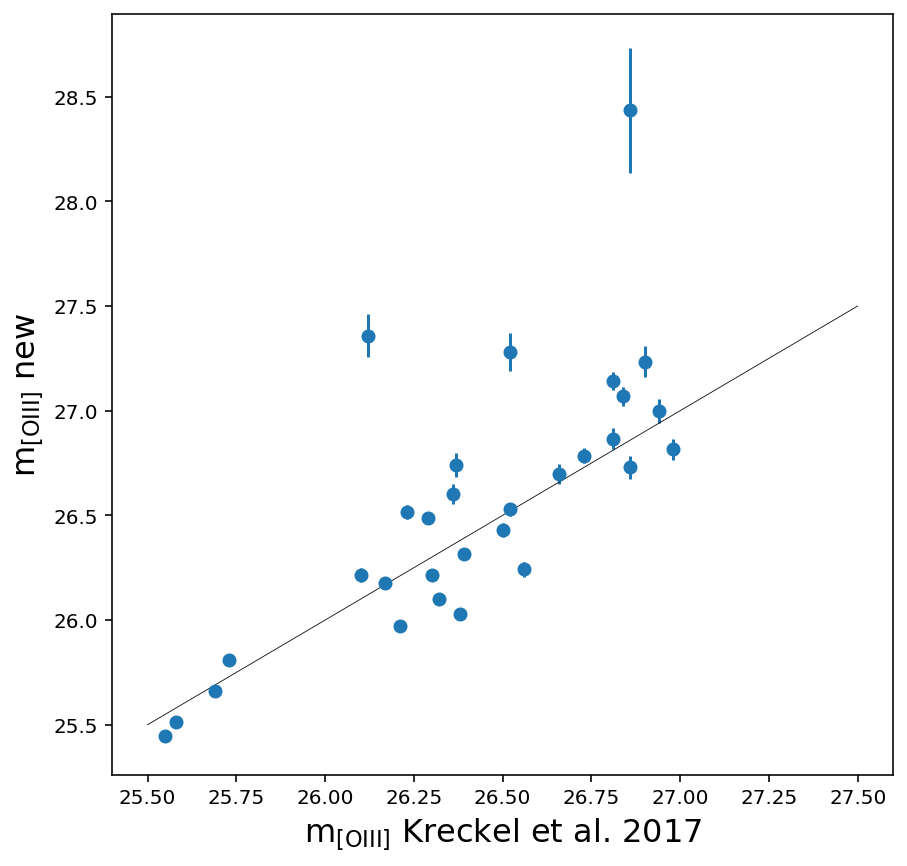

In [33]:
ID, angle, Quantity  = match_coordinates_sky(pn_bright['SkyCoord'],flux['SkyCoord'])

# for each object from Kreckel et al. 2017, we search for the nearest source
# and copy our measured quantities to compare the two
pn_bright['mOIII_measured']  = flux[ID]['mOIII']
pn_bright['dmOIII_measured'] = flux[ID]['dmOIII']
pn_bright['sep'] = angle

# calculate extinction correction (only for non DAP)
extinction = ccm89(wave=np.array([5007.]),a_v=0.2,r_v=3.1,unit='aa')[0]
pn_bright['mOIII_measured'] -= extinction

fig,ax = plt.subplots(figsize=(7,7))

# we only use sources when their position agrees within this tolerance
tolerance = '0.4"'

# calculate the difference in magnitude for those objects
dif = np.mean(np.abs(pn_bright[angle<Angle(tolerance)]['mOIII'] - pn_bright[angle<Angle(tolerance)]['mOIII_measured']))

print(f'{len(pn_bright[angle<Angle(tolerance)])} PN match within {tolerance}')
print(f'the mean deviation is {dif:.3f} dex')

ax.errorbar(pn_bright[angle<Angle(tolerance)]['mOIII'],
            pn_bright[angle<Angle(tolerance)]['mOIII_measured'],
            yerr=pn_bright[angle<Angle(tolerance)]['dmOIII_measured'],
            fmt='o')

ax.plot([25.5,27.5],[25.5,27.5],color='black',lw=0.4)
ax.set_xlabel(r'$\mathrm{m}_{[\mathrm{OIII}]}$ Kreckel et al. 2017',fontsize=16)
ax.set_ylabel(r'$\mathrm{m}_{[\mathrm{OIII}]}$ new',fontsize=16)

plt.show()

## Emission line diagnostics

We built a catalgoue of possible planetary nebula and measuerd different emission lines. However this catalogue still contains objects that are similar to PN like HII regions or supernova remenants (SNR). In this next step we use emission line diagnostics to eliminate those contanimations. The distance modulus $\mu$ is defined as the difference between the apparent and the absolute magnitude. By definition of the absolute magnitude, this relates to the distance $d$ in parsec as 
$$
\begin{align}
\mu = m - M \\
d = 10^{1+\frac{\mu}{5}}
\end{align}
$$

 1. filter out HII regions
    $$
     4 > \log_{10} \frac{[\mathrm{OIII}]}{\mathrm{H}\alpha +[\mathrm{NII}]} > -0.37 M_{[\mathrm{OIII}]} - 1.16
    $$
 2. filter out SNR
    $$
     \mathrm{H}\alpha / [\mathrm{SII}] > 2.5
    $$
    
 3. estimate completness limit (for now I use 28) and remove fainter sources
    

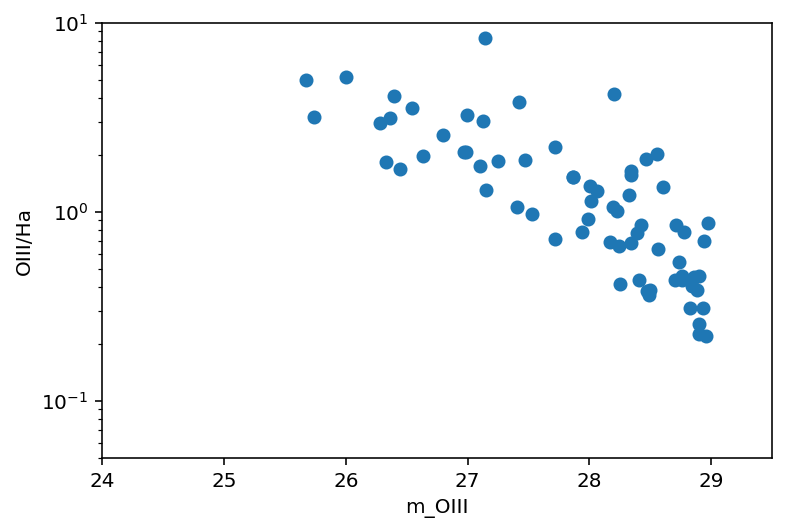

In [81]:
def plot_emission_line_ratio(table):
    
    table = table[(~np.isnan(table['OIII5006'])) & (~np.isnan(table['HA6562']))]
    
    fig, ax = plt.subplots()
    ax.scatter(table['mOIII'],table['OIII5006']/table['HA6562'])
    ax.set(xlim=[24,29.5],
           ylim=[0.05,10],
           yscale='log',
           xlabel='m_OIII',
           ylabel='OIII/Ha')
            
    plt.show()
    
plot_emission_line_ratio(tbl)

In [35]:
# calculate absolute magnitude from distance modulus
mu = 29.91
flux['MOIII'] = flux['mOIII'] - mu

In [36]:

def emission_line_diagnostics(table):
    '''
    
    
    4 > log10 [OIII] / (Ha +[NII]) > -0.37 M[OIII] - 1.16
    
    '''
    
    completeness_limit = 29
        
    # make sure the input is of the correct type
    if not isinstance(table,Table):
        raise TypeError('wrong input')
    
    # next we check if all columns exist
    required = ['OIII5006','HA6562','NII6583','SII6716','mOIII','MOIII']
    missing = set(required) - set(flux.columns)
    if missing:
        raise KeyError(f'input table is missing {", ".join(missing)}')
    del missing
    
    logger.info(f'{len(table)} entries in initial catalogue')

    # remove rows with NaN values in some columns
    mask =  np.ones(len(table), dtype=bool)
    for col in required:
        mask &=  ~np.isnan(table[col])
    table = table[mask]
    logger.info(f'{len(mask[mask==False])} rows were removed because they contain NaN values')

    criteria1 = 4 > np.log10(table['OIII5006'] / (table['HA6562']+table['NII6583']))
    criteria2 = np.log10(table['OIII5006'] / (table['HA6562']+table['NII6583'])) > -0.37*table['MOIII'] - 1.16    
    mask = criteria1 & criteria2
    table = table[mask]
    logger.info(f'{len(mask[mask==False])} objects were removed because they are HII regions')

    criteria3 = table['HA6562'] / table['SII6716'] > 2.5
    table = table[criteria3]
    logger.info(f'{len(criteria3[criteria3==False])} objects were removed because they are SNR')
    
    mask = table['mOIII']< completeness_limit
    table = table[mask]
    logger.info(f'{len(mask[mask==False])} objects below the completness limit removed')    

    logger.info(f'{len(table)} possible planetary nebula found')
    
    return table
    
    
tbl = emission_line_diagnostics(flux)


INFO:__main__:7688 entries in initial catalogue
INFO:__main__:3839 rows were removed because they contain NaN values
INFO:__main__:2762 objects were removed because they are HII regions
INFO:__main__:698 objects were removed because they are SNR
INFO:__main__:235 objects below the completness limit removed
INFO:__main__:154 possible planetary nebula found


In [ ]:
tolerance = '0.5"'
ID, angle, Quantity  = match_coordinates_sky(pn_bright['SkyCoord'],tbl['SkyCoord'])
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'{within_tolerance} of {len(angle)} match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')
print(f'mean seperation is {angle.mean().to_string(u.arcsec,decimal=True)}"')

## Planetary nebula luminosity function



$$ 
\begin{align}
N(M) \propto e^{0.307 M} \left( 1- e^{3(M^*-M)} \right)
\end{align}
$$

### With least square 

 - to use a least square approach we need to bin the data. 
 + easier to implement

In [37]:
import scipy.optimize as optimization
from scipy.optimize import minimize
from inspect import signature

In [ ]:
Mmax = -4.47
delta = 2.5
norm = np.exp(0.307*Mmax - 2.693*delta)*(0.371333 - 3.62866*np.exp(2.693*delta) + 3.25733 * np.exp(3*delta))

norm

mu=29.931, N0=21.69


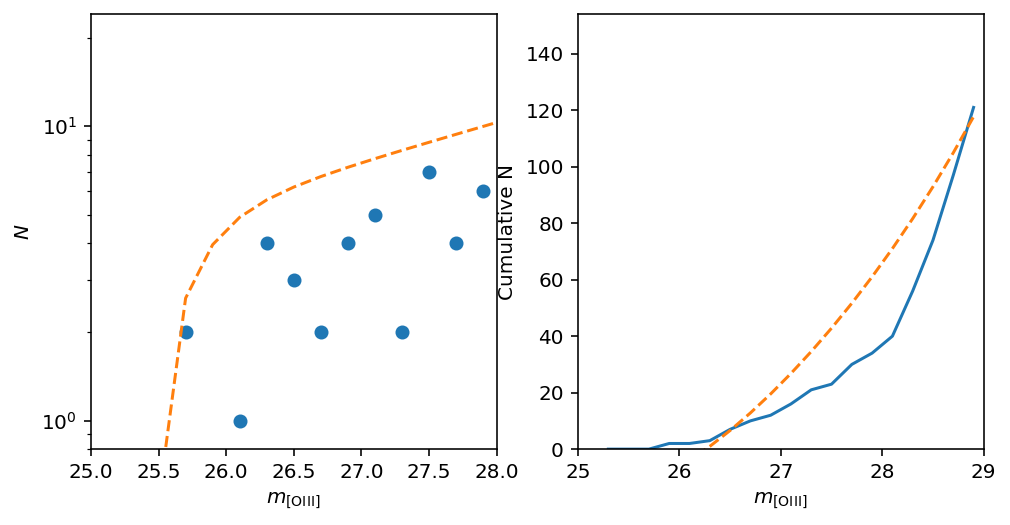

In [69]:
def pnlf(m,mu,N0):
    '''planetary nebula luminosity function
    
    Parameters
    ----------
        
    m : ndarray
        apparent magnitudes of the PNs
        
    mu : float
        distance modulus
    '''
    
    Mmax = -4.47
    delta = 2.5
    norm = np.exp(0.307*Mmax - 2.693*delta)*(0.371333 - 3.62866*np.exp(2.693*delta) + 3.25733 * np.exp(3*delta))
    
    return norm*N0*np.exp(0.307*(m-mu)) * (1-np.exp(3*(Mmax-m+mu)))

def fit_pnlf(table):
    
    binsize = 0.2
    guess = np.array([25,10])
    
    mlow = np.floor(np.min(table))
    mhigh = np.ceil(np.max(table))
    hist,bins  = np.histogram(table,np.arange(mlow,mhigh,binsize))
    
    fit,sig = optimization.curve_fit(pnlf, bins[1:]+binsize/2,hist , guess)
    mu, N0 = fit
    print(f'mu={mu:.3f}, N0={N0:.2f}')
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
    
    ax1.scatter(bins[:-1]+binsize/2,hist)
    ax1.plot(bins[:-1]+binsize/2,pnlf(bins[:-1]+0.1,mu=mu,N0=N0),c='tab:orange',ls='--')
    ax1.set_yscale('log')
    ax1.set_xlim([25,28])
    ax1.set_ylim([0.8,np.max(hist)])
    ax1.set_xlabel('$m_{[\mathrm{OIII}]}$')
    ax1.set_ylabel('$N$')
    
    ax2.plot(bins[1:]+binsize/2,np.cumsum(hist))
    ax2.plot(bins[1:]+binsize/2,np.cumsum(pnlf(bins[:-1]+binsize/2,mu=mu,N0=N0)),ls='--')
    ax2.set_xlim([mlow,mhigh])
    ax2.set_ylim([0,len(table)])
    ax2.set_xlabel('$m_{[\mathrm{OIII}]}$')
    ax2.set_ylabel('Cumulative N')
    
fit_pnlf(tbl['mOIII'])

### With maximum liklihood

Maximum liklihood estimator

In [72]:
Mmax = -4.47
delta = 2.5
norm = np.exp(0.307*Mmax - 2.693*delta)*(0.371333 - 3.62866*np.exp(2.693*delta) + 3.25733 * np.exp(3*delta)) 


class MaximumLikelihood:
    '''
    
    Parameters
    ----------
    func : function
        PDF of the form `func(data,params)`. `func` must accept a
        ndarray for `data` and can have any number of additional
        parameters.
        
    data : ndarray
        Measured data that are feed into `func`.
    '''
    
    def __init__(self,func,data):
        
        self.data = data
        if len(signature(func).parameters)<2:
            raise ValueError(f'`func` must accept at least two arguments')
        self.func = func

    def loglik(self,params):
        '''calculate the log liklihood of the given parameters
        
        This function takes the previously specified PDF and calculates
        the sum of the logarithmic probabilities.
        '''
        
        return np.sum(-np.log(self.func(self.data,*params)))
    
    def fit(self,guess):
        '''use scipy minimize to find the best parameters'''
        
        self.result = minimize(self.loglik,guess,method ='Nelder-Mead')
        for name,var in zip(list(signature(self.func).parameters)[1:],self.result.x):
            print(f'{name}={var:.3g}')
        
    def __call__(self,guess):
        self.fit(guess)
        
fitter = MaximumLikelihood(pnlf,tbl['mOIII'])
fitter([29,20])


mu=-2.71e+03
N0=1.62e+03


In [67]:
def gaussian(x,mu,sig):
    return 1/np.sqrt(2*np.pi*sig**2) * np.exp(-(x-mu)**2/(2*sig**2))

data = np.random.normal(4.2,1.1,50)

fit = MaximumLikelihood(gaussian,data)
fit([3,5])

mu=4.08
sig=1.1
